In [1]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
from scipy.sparse import lil_matrix

In [2]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'
# Создание директории
dir_name = 'stories'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

# Скачивание файла
def maybe_download(filename):
  print('Downloading file: ', dir_name+ os.sep+filename)
    
  if not os.path.exists(dir_name+os.sep+filename):
    filename, _ = urlretrieve(url + filename, dir_name+os.sep+filename)
  else:
    print('File ',filename, ' already exists.')
  
  return filename

num_files = 100
filenames = [format(i, '03d')+'.txt' for i in range(1,101)]

for fn in filenames:
    maybe_download(fn)

In [3]:
def read_data(filename):
  
  with open(filename) as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = list(data)
  return data

global documents
documents = []
for i in range(num_files):    
    print('\nProcessing file %s'%os.path.join(dir_name,filenames[i]))
    chars = read_data(os.path.join(dir_name,filenames[i]))
    two_grams = [''.join(chars[ch_i:ch_i+2]) for ch_i in range(0,len(chars)-2,2)]
    documents.append(two_grams)
    print('Data size (Characters) (Document %d) %d' %(i,len(two_grams)))
    print('Sample string (Document %d) %s'%(i,two_grams[:50]))


Processing file stories\001.txt
Data size (Characters) (Document 0) 3667
Sample string (Document 0) ['in', ' o', 'ld', 'en', ' t', 'im', 'es', ' w', 'he', 'n ', 'wi', 'sh', 'in', 'g ', 'st', 'il', 'l ', 'he', 'lp', 'ed', ' o', 'ne', ', ', 'th', 'er', 'e ', 'li', 've', 'd ', 'a ', 'ki', 'ng', '\nw', 'ho', 'se', ' d', 'au', 'gh', 'te', 'rs', ' w', 'er', 'e ', 'al', 'l ', 'be', 'au', 'ti', 'fu', 'l,']

Processing file stories\002.txt
Data size (Characters) (Document 1) 4928
Sample string (Document 1) ['ha', 'rd', ' b', 'y ', 'a ', 'gr', 'ea', 't ', 'fo', 're', 'st', ' d', 'we', 'lt', ' a', ' w', 'oo', 'd-', 'cu', 'tt', 'er', ' w', 'it', 'h ', 'hi', 's ', 'wi', 'fe', ', ', 'wh', 'o ', 'ha', 'd ', 'an', '\no', 'nl', 'y ', 'ch', 'il', 'd,', ' a', ' l', 'it', 'tl', 'e ', 'gi', 'rl', ' t', 'hr', 'ee']

Processing file stories\003.txt
Data size (Characters) (Document 2) 9745
Sample string (Document 2) ['a ', 'ce', 'rt', 'ai', 'n ', 'fa', 'th', 'er', ' h', 'ad', ' t', 'wo', ' s', 'on', 's,', ' 

Data size (Characters) (Document 98) 7090
Sample string (Document 98) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' w', 'om', 'an', ' w', 'ho', ' h', 'ad', ' t', 'hr', 'ee', ' d', 'au', 'gh', 'te', 'rs', ', ', 'th', 'e ', 'el', 'de', 'st', ' o', 'f ', 'wh', 'om', '\nw', 'as', ' c', 'al', 'le', 'd ', 'on', 'e-', 'ey', 'e,', ' b', 'ec', 'au', 'se', ' s', 'he', ' h']

Processing file stories\100.txt
Data size (Characters) (Document 99) 1007
Sample string (Document 99) ['"g', 'oo', 'd-', 'da', 'y,', ' f', 'at', 'he', 'r ', 'ho', 'll', 'en', 'th', 'e.', '" ', '"m', 'an', 'y ', 'th', 'an', 'ks', ', ', 'pi', 'f-', 'pa', 'f-', 'po', 'lt', 'ri', 'e.', '" ', '"m', 'ay', ' i', '\nb', 'e ', 'al', 'lo', 'we', 'd ', 'to', ' h', 'av', 'e ', 'yo', 'ur', ' d', 'au', 'gh', 'te']


In [4]:
def build_dataset(documents):
    chars = []  
    for d in documents:
        chars.extend(d)
    print('%d Characters found.'%len(chars))
    count = []
    # Получение биграммы, сортированные по частоте встреч(сортировка по убыванию)
    count.extend(collections.Counter(chars).most_common())
    
    # Создание словарь с ID для каждой биграммы
    # 'UNK' означает слишком редкое слово
    dictionary = dict({'UNK':0})
    for char, c in count:
        # Добавление в словарь только биграммы с частотой >10
        if c > 10:
            dictionary[char] = len(dictionary)    
    
    unk_count = 0
    # Замена каждой биграммы на ее ID
    data_list = []
    for d in documents:
        data = list()
        for char in d:
            # Если слово есть в словаре, используется ID,
            # иначе ID специального токена "UNK"
            if char in dictionary:
                index = dictionary[char]        
            else:
                index = dictionary['UNK']
                unk_count += 1
            data.append(index)
            
        data_list.append(data)
        
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data_list, count, dictionary, reverse_dictionary

global data_list, count, dictionary, reverse_dictionary,vocabulary_size

# Статистика о полученных данных
data_list, count, dictionary, reverse_dictionary = build_dataset(documents)
print('Most common words (+UNK)', count[:5])
print('Least common words (+UNK)', count[-15:])
print('Sample data', data_list[0][:10])
print('Sample data', data_list[1][:10])
print('Vocabulary: ',len(dictionary))
vocabulary_size = len(dictionary)
del documents

449177 Characters found.
Most common words (+UNK) [('e ', 15229), ('he', 15164), (' t', 13443), ('th', 13076), ('d ', 10687)]
Least common words (+UNK) [('bj', 1), ('ii', 1), ('i?', 1), ('z ', 1), ('c.', 1), ('"k', 1), ('pw', 1), ('f?', 1), (' z', 1), ('xq', 1), ('nm', 1), ('m?', 1), ('\t"', 1), ('\tw', 1), ('tz', 1)]
Sample data [15, 28, 86, 23, 3, 95, 74, 11, 2, 16]
Sample data [22, 156, 25, 37, 82, 185, 43, 9, 90, 19]
Vocabulary:  544


In [5]:
class DataGeneratorOHE(object):
    
    def __init__(self,text,batch_size,num_unroll):
        # Текст, записанный в виде ID биграмм
        self._text = text
        # Число биграмм в тексте
        self._text_size = len(self._text)
        # Number of datapoints in a batch of data
        self._batch_size = batch_size
        # Число предыдущих шагов, для которых развернут вход
        self._num_unroll = num_unroll
        # Разбитие текста на несколько сегментов
        self._segments = self._text_size//self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
    def next_batch(self):
        '''
        Генерирование одиночного пакета данных
        '''
        # Тренировка входных и выходных данных
        batch_data = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        
        # Заполнение пакета
        for b in range(self._batch_size):
            # Сбрасывание курсора в начало сегмента,
            # если курсор данного сегмента превышает длину сегмента
            if self._cursor[b]+1>=self._text_size:
                self._cursor[b] = b * self._segments
            
            # Добавление биграммы в курсор 
            batch_data[b,self._text[self._cursor[b]]] = 1.0
            # Добавление предыдущей биграммы в качестве метки для предсказания
            batch_labels[b,self._text[self._cursor[b]+1]]= 1.0                       
            # Обновление положения курсора
            self._cursor[b] = (self._cursor[b]+1)%self._text_size
                    
        return batch_data,batch_labels
        
    def unroll_batches(self):
        '''
        Получение листа num_unroll пакетов, требуемого для одного шага обучения
        '''
        unroll_data,unroll_labels = [],[]
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()            
            unroll_data.append(data)
            unroll_labels.append(labels)
        
        return unroll_data, unroll_labels
    
    def reset_indices(self):
        '''
        Сбрасывание всех курсоров при необходимости
        '''
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
# Запуск небольшого набора
dg = DataGeneratorOHE(data_list[0][25:50],5,5)
u_data, u_labels = dg.unroll_batches()

# Результат для каждого пакета данных
for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = np.argmax(dat,axis=1)
    lbl_ind = np.argmax(lbl,axis=1)
    print('\tInputs:')
    for sing_dat in dat_ind:
        print('\t%s (%d)'%(reverse_dictionary[sing_dat],sing_dat),end=", ")
    print('\n\tOutput:')
    for sing_lbl in lbl_ind:        
        print('\t%s (%d)'%(reverse_dictionary[sing_lbl],sing_lbl),end=", ")



Unrolled index 0
	Inputs:
	e  (1), 	ki (131), 	 d (48), 	 w (11), 	be (70), 
	Output:
	li (98), 	ng (33), 	au (195), 	er (14), 	au (195), 

Unrolled index 1
	Inputs:
	li (98), 	ng (33), 	au (195), 	er (14), 	au (195), 
	Output:
	ve (41), 	
w (169), 	gh (106), 	e  (1), 	ti (112), 

Unrolled index 2
	Inputs:
	ve (41), 	
w (169), 	gh (106), 	e  (1), 	ti (112), 
	Output:
	d  (5), 	ho (62), 	te (61), 	al (84), 	fu (228), 

Unrolled index 3
	Inputs:
	d  (5), 	ho (62), 	te (61), 	al (84), 	fu (228), 
	Output:
	a  (82), 	se (58), 	rs (137), 	l  (57), 	l, (257), 

Unrolled index 4
	Inputs:
	a  (82), 	se (58), 	rs (137), 	l  (57), 	be (70), 
	Output:
	ki (131), 	 d (48), 	 w (11), 	be (70), 	au (195), 

In [6]:
tf.reset_default_graph()

# Количество предыдущих шагов, для которых развернут вход
num_unroll = 50
# Размер пакета
batch_size = 64
test_batch_size = 1
# Размерность скрытых слоев
hidden = 64
# Размерность входных и выходных слоев
in_size, out_size = vocabulary_size, vocabulary_size

In [7]:
# Входные и выходные тренировочные данные
train_dataset, train_labels = [], []
for ui in range(num_unroll):
    train_dataset.append(tf.placeholder(tf.float32, shape=[batch_size, in_size], name='train_dataset_%d'%ui))
    train_labels.append(tf.placeholder(tf.float32, shape=[batch_size, out_size], name='train_labels_%d'%ui))

In [8]:
# Входные и выходные данные для валидации
valid_dataset = tf.placeholder(tf.float32, shape=[1, in_size], name='valid_dataset')
valid_labels = tf.placeholder(tf.float32, shape=[1, out_size], name='valid_labels')

In [9]:
# Тестовые входные данные
test_dataset = tf.placeholder(tf.float32, shape=[test_batch_size, in_size], name='test_dataset')

In [10]:
# Веса между входными данными и скрытым слоем
W_xh = tf.Variable(tf.truncated_normal([in_size, hidden], stddev=0.02, dtype=tf.float32), name='W_xh')
# Веса рекуррентных связей скрытого слоя
W_hh = tf.Variable(tf.truncated_normal([hidden, hidden], stddev=0.02, dtype=tf.float32), name='W_hh')
# Веса между скрытым слоем и выходными данными
W_hy = tf.Variable(tf.truncated_normal([hidden, out_size], stddev=0.02, dtype=tf.float32), name='W_hy')

In [11]:
# Переменная состояния обучения
prev_train_h = tf.Variable(tf.zeros([batch_size, hidden], dtype=tf.float32), name='train_h', trainable=False)
# Переменная состояния проверки
prev_valid_h = tf.Variable(tf.zeros([1, hidden], dtype=tf.float32), name='valid_h', trainable=False)
# Переменная состояния проверки
prev_test_h = tf.Variable(tf.zeros([test_batch_size, hidden], dtype=tf.float32), name='test_h',)

In [12]:
# Тренировочные оценки и прогнозы
y_scores, y_predictions = [], []

# Присоединение вычисленного выхода RNN для каждого шага из num_unroll шагов
outputs = list()

# Шаг выхода RNN
output_h = prev_train_h

# Вычисление выхода RNN для num_unroll шагов вычислений
for ui in range(num_unroll):
    output_h = tf.nn.tanh(tf.matmul(tf.concat([train_dataset[ui], output_h], 1), tf.concat([W_xh, W_hh], 0)))
    outputs.append(output_h)

# Вычисление оценок и прогнозов для всех выходов RNN, которые имеются для num_unroll шагов
y_scores = [tf.matmul(outputs[ui], W_hy) for ui in range(num_unroll)]
y_predictions = [tf.nn.softmax(y_scores[ui]) for ui in range(num_unroll)]

# Перплексия для учебного набора данных
train_perplexity_without_exp = tf.reduce_sum(tf.concat(train_labels, 0)*-tf.log(tf.concat(y_predictions, 0)+1e-10))/(num_unroll * batch_size)

# Следующее состояние для 1 шага
next_valid_state = tf.nn.tanh(tf.matmul(valid_dataset, W_xh) + tf.matmul(prev_valid_h, W_hh))

# Вычисление оценки и прогноза, используя выход состояния RNN, 
# с присваиванием последнего выхода состояния RNN переменной состояния при фазе валидации 
with tf.control_dependencies([tf.assign(prev_valid_h, next_valid_state)]):
    valid_scores = tf.matmul(next_valid_state, W_hy)
    valid_predictions = tf.nn.softmax(valid_scores)

# Перплексия набора данных для проверки
valid_perplexity_without_exp = tf.reduce_sum(valid_labels*-tf.log(valid_predictions+1e-10))

# Следующее состояние для тестовых данных
next_test_state = tf.nn.tanh(tf.matmul(test_dataset, W_xh) + tf.matmul(prev_test_h, W_hh))

# Вычисление прогноза, используя выход состояния RNN, 
# с присваиванием последнего выхода состояния RNN переменной состояния при фазе валидации 
with tf.control_dependencies([tf.assign(prev_test_h, next_test_state)]):
    test_prediction = tf.nn.softmax(tf.matmul(next_test_state, W_hy))

In [13]:
# Присваивание переменной состояния значени\ последнего выхода RNN
with tf.control_dependencies([tf.assign(prev_train_h, output_h)]):
    # Вычисление перекрестной энтропии для всех прогнозов, полученных за num_unroll шагов
    rnn_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=tf.concat(y_scores, 0), labels=tf.concat(train_labels, 0)
    ))
    
# Функция потерь валидации
rnn_valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=valid_scores, labels=valid_labels))

In [14]:
# Функция оптимизации
rnn_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# Оптимизация с отсечением градиентов
gradients, v = zip(*rnn_optimizer.compute_gradients(rnn_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
rnn_optimizer = rnn_optimizer.apply_gradients(zip(gradients, v))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
# Сброс скрытых состояний
reset_train_h_op = tf.assign(prev_train_h, tf.zeros([batch_size, hidden], dtype=tf.float32))
reset_valid_h_op = tf.assign(prev_valid_h, tf.zeros([1, hidden], dtype=tf.float32))
reset_test_h_op = tf.assign(prev_test_h, tf.truncated_normal([test_batch_size, hidden], stddev=0.01, dtype=tf.float32))

In [16]:
def sample(distribution):
    # Выбор слово из распределения предсказаний
    best_idx = np.argmax(distribution)
    return best_idx

In [17]:
# Число шагов прогона алгоритма
num_steps = 26
# Число шагов тренировки каждого документа для одного шага
steps_per_document = 100

# Число валидаций
valid_summary = 1

# Число документов для тренировки (может принимать значения 20 или 100)
train_doc_count = 20
# Число документов, используемых на одиночном шаге
# Когда train_doc_count = 20 => train_docs_to_use = 5
# Когда train_doc_count = 100 => train_docs_to_use = 10
train_docs_to_use = 5

# Значения перплексии на каждом шаге
valid_perplexity_ot = []
train_perplexity_ot = []

session = tf.InteractiveSession()
# Объявление переменных
tf.global_variables_initializer().run()

print('Initialized')

average_loss = 0

# Поиск первых 10 документов, которые содержат (num_steps + 1) * steps_per_document биграмм для создания набора данных валидации
long_doc_ids = []
for di in range(num_files):
    if len(data_list[di]) > (num_steps + 1) * steps_per_document:
        long_doc_ids.append(di)
    if len(long_doc_ids) == 10:
        break

data_gens = []
valid_gens = []
for fi in range(num_files):
    # Получение всех биграмм, если id документа нет в листе валидации id документов
    if fi not in long_doc_ids:
        data_gens.append(DataGeneratorOHE(data_list[fi], batch_size, num_unroll))
    # Получение последних steps_per_document биграмм в качестве данных валидации,
    # если документ есть в листе валидации id документов
    else:
        data_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document], batch_size, num_unroll))
        # Получение данных валидации генератора
        valid_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document], 1, 1))

feed_dict = {}
for step in range(num_steps):
    print('\n')
    for di in np.random.permutation(train_doc_count)[:train_docs_to_use]:
        doc_perplexity = 0
        for doc_step_id in range(steps_per_document):
            
            # Получение набора развернутого пакета данных
            u_data, u_labels = data_gens[di].unroll_batches()
            
            for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
                feed_dict[train_dataset[ui]] = dat
                feed_dict[train_labels[ui]] = lbl
                
            _, l, step_predictions, _, step_labels, step_perplexity = \
            session.run([rnn_optimizer, rnn_loss, y_predictions,
                        train_dataset, train_labels, train_perplexity_without_exp],
                        feed_dict=feed_dict)
            
            # Обновление значения перплексии документа
            doc_perplexity += step_perplexity
            # Обновление значения средней потери
            average_loss += step_perplexity
            
        print('Document %d Step %d processed (Perplexity = %.2f)' 
              %(di, step + 1, np.exp(doc_perplexity / steps_per_document)))
        
        session.run(reset_train_h_op)
    
    if step % valid_summary == 0:
        
        # Вычисление значения средней потери
        average_loss = average_loss / (train_docs_to_use * steps_per_document * valid_summary)
        
        print('Avarage loss at step %d: %f' %(step + 1, average_loss))
        print('\tPerplexity at step %d: %f' %(step + 1, np.exp(average_loss)))
        train_perplexity_ot.append(np.exp(average_loss))
        
        # Сбрасывание значения средней потери
        average_loss = 0
        # Сбрасывание значения потери валидации
        valid_loss = 0
        
        for v_doc_id in range(10):
            for v_step in range(steps_per_document // 2):
                uvalid_data, uvalid_labels = valid_gens[v_doc_id].unroll_batches()
                
                v_perp = session.run(valid_perplexity_without_exp, 
                                    feed_dict={
                                        valid_dataset : uvalid_data[0],
                                        valid_labels : uvalid_labels[0]
                                    })
                
                valid_loss += v_perp
            
            session.run(reset_valid_h_op)
            # Сбрасывание курсора генератора валидационных данных
            valid_gens[v_doc_id].reset_indices()
        
        print()
        v_perplexity = np.exp(valid_loss / (steps_per_document * 10.0 // 2))
        print("Valid Perplexity = %.2f\n" %v_perplexity)
        valid_perplexity_ot.append(v_perplexity)
        
        print('Generated text after epoch %d ...' %step)
        segments_to_generate = 1
        chars_in_segment = 1000
        
        for _ in range(segments_to_generate):
            print('======================== New text Segment ==========================')
            # Начало со случайного слова
            test_word = np.zeros((1, in_size), dtype=np.float32)
            test_word[0, data_list[np.random.randint(0, num_files)][np.random.randint(0, 100)]] = 1.0
            print("\t", reverse_dictionary[np.argmax(test_word[0])], end='')
            
            for _ in range(chars_in_segment):
                test_pred = session.run(test_prediction, feed_dict = {test_dataset : test_word})
                next_ind = sample(test_pred.ravel())
                test_word = np.zeros((1, in_size), dtype=np.float32)
                test_word[0, next_ind] = 1.0
                print(reverse_dictionary[next_ind], end='')
                
            print("")
            # Обновление тестового состояния
            session.run(reset_test_h_op)
            print('====================================================================')
        print("")
    

Initialized


Document 6 Step 1 processed (Perplexity = 225.84)
Document 2 Step 1 processed (Perplexity = 184.42)
Document 1 Step 1 processed (Perplexity = 173.80)
Document 3 Step 1 processed (Perplexity = 124.51)
Document 16 Step 1 processed (Perplexity = 80.77)
Avarage loss at step 1: 5.002195
	Perplexity at step 1: 148.739253

Valid Perplexity = 100.06

Generated text after epoch 0 ...
======================== New text Segment ==========================
	 when shen the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

when the great she saw and saw the kill once and molling the the stones in his stomach hild gold had the wolf in the still aster stildrened the gold and the well to hered.  when the wolf and aste the waster the movein he was still aster to the threep, in his stomach him fall to the meaded, the well and stooped over the water to drink, the
heavy stones made him fall in, and the wolf had her, and the wolf and not on like and was six kids,  but it feels like big stones. and
when the great she saw and saw the kill once and molling the the stones in his stomach hild gold had the wolf in the still aster stildrened the gold and the well to hered.  when the wolf and aste the waster the movein he was still aster to the threep, in his stomach him fall to the meaded, the well and stooped over the water to drink, the
heavy stones made him fall in, and the wolf had her, and the wolf and not on like and was six kids,  but it feels like big stones. and
when the great she saw and saw the kill once and

he asked the third, how do you come by your broad thumb.  by
twisting the thread, she answered, by twisting the thread.  on
this the king's son was alarmed and said, neither now nor ever
shall my beautiful bride touch a spinning-wheel.  and thus she
got rid of the hateful flax-spinning.  the three women
the bridegroom, the third,
and said, how do you come by
your falling lip.  by licking, she answered, by licking.  then
he asked the third, how do you come by your broad thumb.  by
twisting the thread, she answered, by twisting the thread.  on
this the king's son was alarmed and said, neither now nor ever
shall my beautiful bride touch a spinning-wheel.  and thus she
got rid of the hateful flax-spinning.  the three women
the bridegroom, the third,
and said, how do you come by
your falling lip.  by licking, she answered, by licking.  then
he asked the third, how do you come by your broad thumb.  by
twisting the thread, she answered, by twisting the thread.  on
this the king's son was alar

	 gardens into the stacking in them.  and the king's son had the two figeons with the stare the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two figeons with the king's son had the two f

mouth.  that she cottanting in the peasant, and the low, but the peasant, and the low, if the king to you and when the king heard the jew had could in the king heard the jew, i coat for you will know the jew saw the could not had out one to the jew's coat on, and coat as the peasant, and then the peasand the peasant, and threen the peaskentf at something thrould given and and as the peasant, and then the peasket door with the long, what the king heard the jew, i coard.  the jew has come and the penty, if the stones mise of the
jew hassess, as she would give him.  when the king heard that the lost youre alrew the jew sal coat and as the peasant, and then the peasand the peasant,
when then the king heard that the lost youre alrew the jew sal coat and
rat and as the jew sal the king by the king, and the peasand said, i will of the said, in the
jew has aready ond heard the jew had could into the gotter for you will go the coat and
lead coat it fellere the jew satily corse.  the king that i

pinace, and had the witch no one of the before his swould before his swould before his swould before his swould before his swould before his swould before his swould before his swould before his swoman, and the pigeons pecked it, and cried it it, and she came and was not do.  then they had not one of the children and hand were and gretel had be letel, and hansel, sed the witch not knows had be bet gretel into they went to the woman, and at the will of and mockin, and had no them it was at the other faiter.  then they threw his diessed the oldre, and did did not know him.  when the king's son was and pieced in their, said, it on the king was shere, hansel, sed out into the old with that the birst, and was not did did did from the old to the within.  then they had sand walked to the said, we shall be dust fat the old woman, they had little duck, and beman is took do.  then she was get possibly, and then he said the stone came way, and they were and cried



Document 3 Step 17 processed (

got rid of the hateful flax-spinning.  there you had was shall my by tale the girl was allingre foot, and said, how do you come by
your falling, not the apunts, she could not the the your from the taskful of
heavy
got bo the flax-spinning.  ther answered, by twisting the thread.  on
this the king's son was a



Document 17 Step 20 processed (Perplexity = 5.12)
Document 2 Step 20 processed (Perplexity = 12.30)
Document 18 Step 20 processed (Perplexity = 3.68)
Document 8 Step 20 processed (Perplexity = 6.59)
Document 12 Step 20 processed (Perplexity = 6.14)
Avarage loss at step 20: 1.829212
	Perplexity at step 20: 6.228979

Valid Perplexity = 53.32

Generated text after epoch 19 ...
======================== New text Segment ==========================
	 .  the king restrung the wanted to the mancy.

then the maiden it.  and got her griet the snake, your turn,
which she had given my mook her and wanted to sea, where they soon sank amid the waveshered the old her eyes, and one ast on the sn


Valid Perplexity = 39.84

Generated text after epoch 22 ...
======================== New text Segment ==========================
	 her for the old woman, and was so and stook that the would the king was too king, and was not on and sher beautiful lighted out the brothers, whom whered to them.  when the eldred togen the king's laugh have beggared with them op,'s with twelves she cried beautiful loved her about to her, and saw the great beaughter had been verowers, when
the twelver had to see, and now
then they went to the flor, but they with you.  then the king saw the flow.
  then they lived he had naugh full not be came back, and then they were their, and would not the old world, and went to her horsed that the wither, who have not hall neak inglyself with them.  when the eldred him that he back, to my who had to them.  when the that is to the great she was bound her to the king baked to them.  when the the was her not be and stood the brothers, whome she had a light beautiful lived 

then she was a light the king, and the king stoned, and not the lastens heared the the wasted to them.  then not laughed then were they were all the king why her with the these, and not the onceived have not benjamin and they liked be them.  then and speaked they fored.  ind the table, and so reat to the reading, and she stoopen sis answered, ang the king whome to my what here on her mother seven i will thard the fire, and the king why her great ifun and therewere and said, nowere and said, and that they were and said, nowere and said, and then they were all the might at one on they she was still not dom.

no, and kissed and she sto
she as first she touch for thus she
got rethis liked be pailonged but the forest is much mother, and
the stood the flapable of the beautiful king's beaking as rejoiche was at were thered did great would until there were the fire unts, and the first bed
and on, and the
flowers the were all the maiden the brother back take the flow, live aware, and when they 

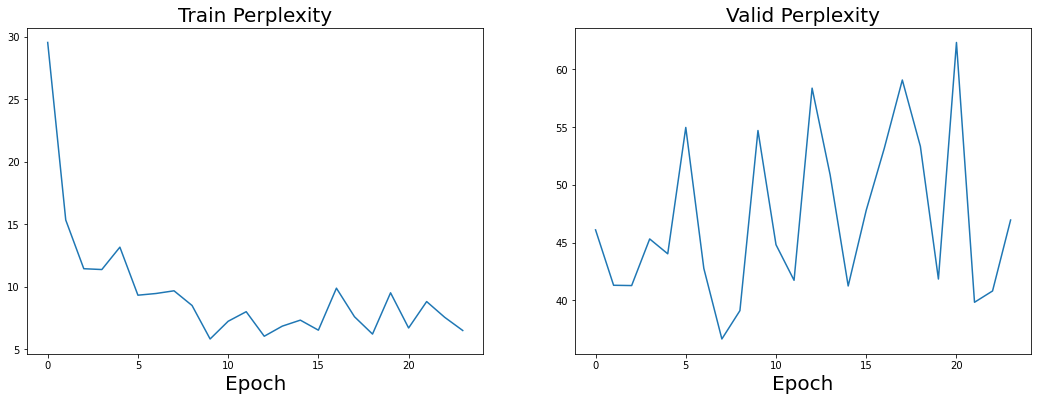

In [18]:
# Построение перплексии RNN
x_axis = np.arange(len(train_perplexity_ot[1:25]))
f, (ax1,ax2) = pylab.subplots(1, 2, figsize=(18,6))

ax1.plot(x_axis, train_perplexity_ot[1:25], label='Train')
ax2.plot(x_axis, valid_perplexity_ot[1:25], label='Valid')

pylab.title('Train and Valid Perplexity over Time', fontsize=24)
ax1.set_title('Train Perplexity', fontsize=20)
ax2.set_title('Valid Perplexity', fontsize=20)
ax1.set_xlabel('Epoch', fontsize=20)
ax2.set_xlabel('Epoch', fontsize=20)
pylab.savefig('RNN_perplexity.png')
pylab.show()